In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

from dataclasses import dataclass
from functools import partial

jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [2]:
# Black Scholes
# helper analytics    
@jit
def bsPrice(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5 * vol * vol * T) / vol / jnp.sqrt(T)
    d2 = d1 - vol * jnp.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

@jit
def bsDelta(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5 * vol * vol * T) / vol / jnp.sqrt(T)
    return norm.cdf(d1)

@jit
def bsVega(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5 * vol * vol * T) / vol / jnp.sqrt(T)
    return spot * jnp.sqrt(T) * norm.pdf(d1)

@dataclass
class BlackScholes:
    
    spot: int = 1
    vol: float = 0.2
    T1: int = 1
    T2: int = 2
    K: float = 1.10
    volMult: float = 1.5
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    # @partial(jit, static_argnums=(0,))
    def trainingSet(self, m, anti=True, seed=42):
    
        key = random.PRNGKey(seed)
        # 2 sets of normal returns
        returns = random.normal(key, shape=(m, 2))

        # SDE
        vol0 = self.vol * self.volMult
        R1 = jnp.exp(-0.5*vol0*vol0*self.T1 + vol0*jnp.sqrt(self.T1)*returns[:,0])
        R2 = jnp.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*jnp.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = jnp.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = jnp.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*jnp.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = jnp.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  jnp.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  jnp.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  jnp.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=42):
        
        spots = jnp.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas 

In [4]:
bs = BlackScholes()
x_train, y_train, dydx_train = bs.trainingSet(10 * 8192)
x_test, x_axis, y_test, dydx_test, vegas = bs.testSet(num=1000)

In [5]:
def plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test):
    plt.title("Training Data")
    # the same as plt.scatter(x_train, y_train) but with a thinner line is:
    plt.plot(x_train, y_train, 'r.', markersize=1)
    # now the other two with a thinner line:
    plt.plot(x_test, y_test, 'b.', markersize=1)
    plt.plot(x_train, dydx_train, 'g.', markersize=1)
    # plt.plot(x_axis, dydx_test, 'g.', markersize=1)
    # corresponding legend:
    plt.legend(['Training Data', 'True Price', 'Training Delta'], loc='upper left')
    plt.show()

In [6]:
print(x_train.shape, y_train.shape, dydx_train.shape)
print(x_test.shape, y_test.shape, x_axis.shape, dydx_test.shape, vegas.shape)

(81920, 1) (81920, 1) (81920, 1)
(1000, 1) (1000, 1) (1000, 1) (1000, 1) (1000, 1)


In [7]:
x_train

DeviceArray([[1.015608  ],
             [0.7214727 ],
             [0.71184325],
             ...,
             [1.2816817 ],
             [0.6581382 ],
             [0.7271205 ]], dtype=float32)

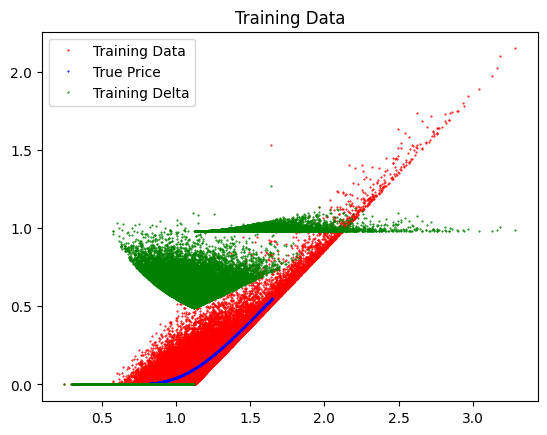

In [8]:
plot_training_data(x_train, y_train, dydx_train, x_test, y_test, x_axis, dydx_test)

In [9]:
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(x_train)
y_train, y_train_mean, y_train_std = normalize(y_train)
dydx_train, dydx_train_mean, dydx_train_std = normalize(dydx_train)

In [10]:
x_train.std()

DeviceArray(1., dtype=float32)

In [56]:
# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 10
seed = 42

key = jax.random.PRNGKey(seed)

In [12]:
key, subkey = jax.random.split(key)
model = eqx.nn.MLP(key=subkey, in_size=1, out_size=1, width_size=20, depth=3, activation=jax.nn.elu)
model

MLP(
  layers=[
    Linear(
      weight=f32[20,1],
      bias=f32[20],
      in_features=1,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f32[20,20],
      bias=f32[20],
      in_features=20,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f32[20,20],
      bias=f32[20],
      in_features=20,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f32[1,20],
      bias=f32[1],
      in_features=20,
      out_features=1,
      use_bias=True
    )
  ],
  activation=<wrapped function elu>,
  final_activation=<function _identity>,
  in_size=1,
  out_size=1,
  width_size=20,
  depth=3
)

In [13]:
# modified initialization

def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

key, subkey = jax.random.split(key)

model = init_linear_weight(model, trunc_init, key)

In [14]:
@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

In [15]:
class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

model_scalar = MakeScalar(model)

In [16]:
res = vmap(eqx.filter_value_and_grad(model_scalar))(x_train)
print(res)

(DeviceArray([-0.32768852, -0.34796125, -0.3466364 , ..., -0.21479785,
             -0.3363753 , -0.34867918], dtype=float32), DeviceArray([[ 0.07963183],
             [-0.04042998],
             [-0.04453812],
             ...,
             [ 0.17024711],
             [-0.07691903],
             [-0.03804263]], dtype=float32))


In [70]:
vmap_vjp = vmap(jax.vjp, in_axes=(None, 0))
res_old = vmap_vjp(model, x_train)

print(res_old[0].shape)
print(res[1])
# print(res)

# value_and_jacobian(model, x_train[0])
# res = eqx.filter_vmap(lambda x: value_and_jacrev(model, x))(x_train)
res = eqx.filter_vmap(partial(value_and_jacrev, model))(x_train)
# print(res)

# print(res[0].shape)
# print(res[0] - res_old[0])
# print(res_old[1].shape)

# eqx.filter_value_and_grad(model)(x_train)

# vmap(eqx.filter_value_and_grad(model))(x_train)

(81920, 1)
[[[ 0.07963187]]

 [[-0.04043   ]]

 [[-0.04453815]]

 ...

 [[ 0.17024711]]

 [[-0.07691909]]

 [[-0.03804267]]]


In [66]:
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    # alpha = 1.0/(1.0 + lambda_scale)
    # beta = lambda_scale/(1.0 + lambda_scale)

    alpha = 0.5
    beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)
    # y_pred, dydx_pred,  = eqx.filter_vmap(partial(value_and_jacrev, model))(x_train)

    # y_pred = vmap(model)(x)
    y_pred = y_pred[..., jnp.newaxis]
    dydx_pred = dydx_pred

    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    # y_pred_prev = vmap(model)(x)

    # jax.debug.print("{norm}", norm=jnp.linalg.norm(y_pred - y_pred_prev))

    # jax.debug.print("{y}", y=y_pred)
    # jax.debug.print("{y_pred_prev}", y_pred_prev=y_pred_prev)

    # jax.debug.print("{y_shape}", y_shape=y_pred.shape)
    # jax.debug.print("{dydx_pred}", dydx_pred=dydx_pred)
    # jax.debug.print("{dydx_shape}", dydx_shape=dydx_pred.shape)

    loss = alpha * jnp.mean((y_pred - y)**2) + beta * jnp.mean((dydx_pred - dydx)**2)
    # loss = alpha * jnp.mean((y_pred - y)**2)
    return loss

In [67]:
def train(model: eqx.nn.MLP,
          x: Float[Array, "n"],
          y: Float[Array, "n"],
          dydx: Float[Array, "n"],
          optim: optax.GradientTransformation,
          steps: int
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"],
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    n_batches = (len(x) // batch_size)
    for step in range(n_batches):
        batch_x = x[step*batch_size:(step+1)*batch_size]
        batch_y = y[step*batch_size:(step+1)*batch_size]
        batch_dydx = dydx[step*batch_size:(step+1)*batch_size]

        model, opt_state, loss_value = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

        if (step % 100 == 0) or (step == steps-1):
            test_loss = loss_fn(model, (x_test - x_train_mean) / x_train_std, (y_test - y_train_mean) / y_train_std, (dydx_test - dydx_train_mean) / dydx_train_std)
            print(f"step: {step}, train_loss: {loss_value}, test_loss: {test_loss}")
    
    return model

In [68]:
optim = optax.adam(learning_rate)
model_scalar = train(model_scalar, x_train, y_train, dydx_train, optim, steps=10000)

step: 0, train_loss: 0.23197031021118164, test_loss: 0.16124773025512695
step: 100, train_loss: 0.34692710638046265, test_loss: 0.1316004991531372
step: 200, train_loss: 0.2542960047721863, test_loss: 0.1477731466293335
step: 300, train_loss: 0.2715083658695221, test_loss: 0.15391618013381958
step: 400, train_loss: 0.27912211418151855, test_loss: 0.12864230573177338
step: 500, train_loss: 0.2402639091014862, test_loss: 0.1396210640668869
step: 600, train_loss: 0.2682356834411621, test_loss: 0.13710902631282806


In [49]:
vmap(model_scalar)(x_test).shape

(1000,)

(1000, 1)
RMSE: 0.09441976994276047


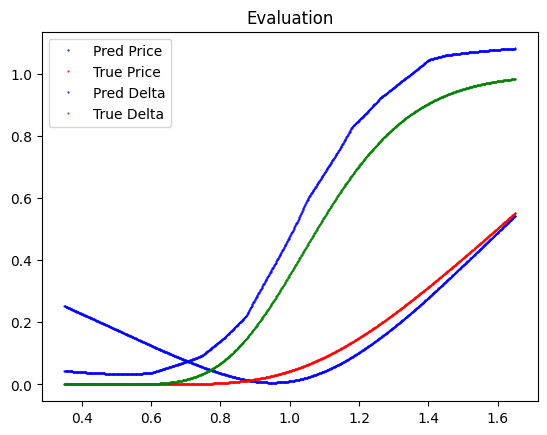

In [50]:
# predict
x = (x_test - x_train_mean) / x_train_std
# pred = vmap(model_scalar)(x)
pred, pred_dydx = vmap(eqx.filter_value_and_grad(model_scalar))(x)

pred_y = pred * y_train_std + y_train_mean
pred_y = pred_y[..., jnp.newaxis]

pred_dydx = pred_dydx * dydx_train_std + dydx_train_mean
# pred_dydx = pred_dydx[..., jnp.newaxis]

print(pred_y.shape)

# evaluate
def eval_rmse(y_true: Array, y_pred: Array) -> float:
    return jnp.sqrt(jnp.mean((y_true - y_pred) ** 2))

# print the above line:
print(f"RMSE: {eval_rmse(y_test, pred_y)}")

plt.title("Evaluation")
plt.plot(x_test, pred_y, 'b.', markersize=1)
plt.plot(x_test, y_test, 'r.', markersize=1)
plt.plot(x_test, pred_dydx, 'b.', markersize=1)
plt.plot(x_test, dydx_test, 'g.', markersize=1)
plt.legend(['Pred Price', 'True Price', 'Pred Delta', "True Delta"], loc='upper left')
plt.show()